In [2]:
%cd /scratch/bruingjde/SNAM2021-code/

from constants import *

/scratch/bruingjde/SNAM2021-code


# Time agnostic

In [3]:
def logistic_regression_I(network: int):
  X = dict()
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy')
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000)) # type: ignore
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1]) # type: ignore
  
  return auc

time_agnostic_performance = {
  network: logistic_regression_I(network) for network in network_indices}

# Time aware

In [4]:
def logistic_regression_I_II_III_hypergraph(network: int):
  X = dict()
  # Type I features
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
    
  # Type II features
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1', 'm2', 'm3']:
        X[(time_strategy, nodepair_strategy, aggregation_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}_{aggregation_strategy}.npy'))
  # Type III features      
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      for aggregation_strategy in ['q0', 'q25', 'q50', 'q75', 'q100', 
                                   'm0', 'm1']:
          X[(heuristic, time_strategy, aggregation_strategy)] = (
            np.load(
              f'data/{network:02}/features/time_edge/'
              f'{heuristic}_{time_strategy}_{aggregation_strategy}.npy'))
    
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

def logistic_regression_I_II_III_simplegraph(network: int):
  X = dict()
  # Type I
  for heuristic in ['aa', 'cn', 'jc', 'pa']:
    X[heuristic] = (
      np.load(f'data/{network:02}/features/time_agnostic/{heuristic}.npy'))
  # Type II 
  for time_strategy in time_strategies:
    for nodepair_strategy in nodepair_strategies:
        X[(time_strategy, nodepair_strategy)] = (
          np.load(
            f'data/{network:02}/features/time_node/'
            f'{time_strategy}_{nodepair_strategy}.npy'))
  # Type III
  for heuristic in ['aa', 'cn', 'jc', 'pa']:  
    for time_strategy in time_strategies:
      X[(heuristic, time_strategy)] = (
        np.load(
          f'data/{network:02}/features/time_edge/'
          f'{heuristic}_{time_strategy}.npy'))
      
  X = pd.DataFrame(X)
    
  y = np.load(f'data/{network:02}/targets_sampled.npy')
  
  X_train, X_test, y_train, y_test = (
    sklearn.model_selection.train_test_split(X, y))
  pipe = sklearn.pipeline.make_pipeline(
    sklearn.preprocessing.StandardScaler(),
    sklearn.linear_model.LogisticRegression(max_iter=10000))
  pipe.fit(X_train, y_train)
  
  auc = sklearn.metrics.roc_auc_score(
    y_true=y_test, y_score=pipe.predict_proba(X_test)[:,1])
  
  return auc

time_aware_performance = {
  network: logistic_regression_I_II_III_hypergraph(network) 
  for network in hypergraph_indices} | {
  network: logistic_regression_I_II_III_simplegraph(network) 
  for network in simplegraph_indices
}

In [5]:
get_networks()

,label,old_category,source,category
1,DBLP,Coauthorship,Ley2002,social
2,HepPh,Cocitation,Leskovec2007,information
3,Enron,Communication,Klimt2004,social
4,FB-w,Social,Viswanath2009,social
5,Condm,Coauthorship,Lichtenwalter2010,social
6,HepTh,Cocitation,Leskovec2007,information
7,AMin,Coauthorship,Zhuang2013,social
8,FB-l,Social,Viswanath2009,social
9,D-rep,Communication,DeChoudhury2009,social
10,D-f,Social,Hogg2010,social


In [6]:
ylabel = 'time aware (AUC)'
xlabel = 'time agnostic (AUC)'

df = pd.concat(
  {
    ylabel: pd.Series(time_aware_performance), 
    xlabel: pd.Series(time_agnostic_performance)
  },
  axis=1)
df['category'] = get_networks()['category']

In [7]:
df.rename(columns={'category': 'Scientific domain'}, inplace=True)
df.replace({'Scientific domain': {'social': 'Social', 'information': 'Information', 'technological': 'Technological'}}, inplace=True)

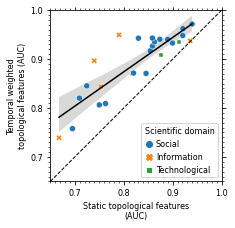

In [42]:
auc_values = df[[ylabel, xlabel]].values.flatten()
lim = (min(auc_values), 1)

fontsize=8
rc = {
  'xtick.top': True, 'ytick.right': True, 'figure.figsize': (3.30,3.3), 
  'axes.titlesize': fontsize, 
  'axes.labelsize': fontsize, 
  'xtick.labelsize': fontsize, 
  'ytick.labelsize': fontsize, 
  'legend.fontsize': fontsize, 
  'legend.title_fontsize': fontsize,
  'lines.linewidth': 1,
#   'lines.markersize': 4,
  'legend.handlelength': .1,
  'font.family': 'sans-serif',
  'font.sans-serif': 'Helvetica',
  'savefig.transparent': True
}

with plt.rc_context(rc):
  ax = sns.regplot(data=df, x=xlabel, y=ylabel, scatter=False, color='black')
  sns.scatterplot(data=df, x=xlabel, y=ylabel, 
                  hue='Scientific domain', style='Scientific domain', ax=ax)
  ax.axline((0,0), (1,1), ls='--', c='black')
  ax.axis('scaled')
  ax.axis([.65, 1, .65, 1])
  ax.set_xlabel('Static topological features\n(AUC)')
  ax.set_ylabel('Temporal weighted\ntopological features (AUC)')
  ax.xaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.yaxis.set_minor_locator(matplotlib.ticker.MultipleLocator(.01))
  ax.xaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
  ax.yaxis.set_major_locator(matplotlib.ticker.MultipleLocator(.1))
#   plt.legend()
  plt.tight_layout()
  plt.savefig('code/figures/output/Fig3.pdf')

In [39]:
matplotlib.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-5, 6],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f